# Music Popularity Model Runs

### Data Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pylab as pl
from scipy import stats
import math 

%matplotlib inline
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split #All ML libaries
from sklearn import tree 
from sklearn import metrics

In [3]:
# Load in the data with `read_csv()`
features = pd.read_csv("features_with_headers.csv",
                     header=0)

tracks = pd.read_csv("tracks_with_headers.csv",
                   header=0)

In [4]:
tracks_sub = tracks[['track_id','track_genre_top','artist_name', 'track_title','track_duration','track_listens']]
tf = tracks_sub.merge(features, left_on='track_id', right_on='track_id', how='inner')
tf.head(5)

,track_id,track_genre_top,artist_name,track_title,track_duration,track_listens,chroma_cens_kurtosis_1,chroma_cens_kurtosis_2,chroma_cens_kurtosis_3,chroma_cens_kurtosis_4,...,tonnetz_std_4,tonnetz_std_5,tonnetz_std_6,zcr_kurtosis_1,zcr_max_1,zcr_mean_1,zcr_median_1,zcr_min_1,zcr_skew_1,zcr_std_1
0,2,Hip-Hop,AWOL,Food,168.0,1293.0,7.180,5.2300,0.249,1.350,...,0.0541,0.0122,0.0121,5.76,0.459,0.0856,0.0713,0.000000,2.09,0.0614
1,3,Hip-Hop,AWOL,Electric Ave,237.0,514.0,1.890,0.7610,0.345,2.300,...,0.0638,0.0142,0.0177,2.82,0.466,0.0846,0.0640,0.000000,1.72,0.0693
2,5,Hip-Hop,AWOL,This World,206.0,1151.0,0.528,-0.0777,-0.280,0.686,...,0.0407,0.0127,0.0148,6.81,0.375,0.0531,0.0415,0.000000,2.19,0.0449
3,10,Pop,Kurt Vile,Freeway,161.0,50135.0,3.700,-0.2910,2.200,-0.234,...,0.0744,0.0180,0.0139,21.40,0.452,0.0775,0.0718,0.000000,3.54,0.0408
4,20,NaN,Nicky Cook,Spiritual Level,311.0,361.0,-0.194,-0.1990,0.202,0.259,...,0.0950,0.0225,0.0214,16.70,0.470,0.0472,0.0400,0.000977,3.19,0.0310


### Remove artist from the sample for out of sample testing

In [8]:
artist_label="Saylavees"

sample = tf[(tf.artist_name==artist_label)]
sample = sample.iloc[:, 4:523]

modelData = tf[(tf.artist_name!=artist_label)]

print(tf.shape)
print(sample.shape)
print(modelData.shape)

genre_label = 'Rock'
genre = modelData[(modelData.track_genre_top==genre_label)]
genre = genre.dropna()

(106573, 524)
(8, 519)
(106565, 524)


### Remove Outliers

In [9]:
genre_o = genre.copy()
genre_o = genre_o.iloc[:, 4:523] 

z = np.abs(stats.zscore(genre_o))

# Find values causing zscore errors
zdf = pd.DataFrame(z, columns=genre_o.columns.values)
zdf.head(5)
invalid = zdf.isnull().any()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #display(invalid)
    
#Remove columns causing the issues
drop_col = ["chroma_stft_max_12"] #Rock 

genre_o = genre_o.drop(columns=drop_col)
sample = sample.drop(columns=drop_col)

z = np.abs(stats.zscore(genre_o))
genre_o = genre_o[(z < 3).all(axis=1)]


C:\Users\jgorsett\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


### Create popularity feature and data frames for the model

In [11]:
target = genre_o.track_listens

genre_p = genre_o.copy()
genre_p = genre_p.assign(popularity=pd.qcut(target, 3, labels=["low", "med", "high"]))
genre_p.popularity = genre_p.popularity.replace(to_replace=["low","med", "high"], value=[0,0,1])

popular = genre_p.track_listens[genre_p.popularity==1].aggregate('count')
notpopular = genre_p.track_listens[genre_p.popularity==0].aggregate('count')

print(popular)
print(notpopular)

pop_data = genre_p.drop(columns=['track_listens','popularity'])
pop_target = genre_p.popularity

# Get actual popularity for sample
min_track_listens = genre_p.track_listens[genre_p.popularity==1].aggregate('min')
sample_target = np.where(sample['track_listens']<min_track_listens, 0, 1)
sample_data = sample.drop(columns=['track_listens'])

1362
2724


## Models

### PCA

In [12]:
scaler = StandardScaler()
scaler.fit(pop_data)
X_scaled = scaler.transform(pop_data)

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=350)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_.sum())
x_pc = pca.fit_transform(X_scaled)[:,:350]


0.9961743343972975


### Decision Tree

In [36]:
#1) and 3)
X_train, X_test, y_train, y_test = train_test_split(pop_data, pop_target, test_size=0.2, random_state=2018, shuffle=True)
#2)
#X_train, X_test, y_train, y_test = train_test_split(x_pc, pop_target, test_size=0.2, random_state=2018, shuffle=True)

In [37]:
print(X_train.shape)
print(X_test.shape)

(3268, 350)
(818, 350)


In [47]:
#1
dec_tree = tree.DecisionTreeClassifier(random_state=2018)
#2 and #3
#dec_tree = tree.DecisionTreeClassifier(random_state=2018, max_depth=5)

dec_tree = dec_tree.fit(X_train, y_train)

In [48]:
pred_test = dec_tree.predict(X_test) # Predict the labels
pred_test_prob = dec_tree.predict_proba(X_test) # Predict the probabilities

In [49]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

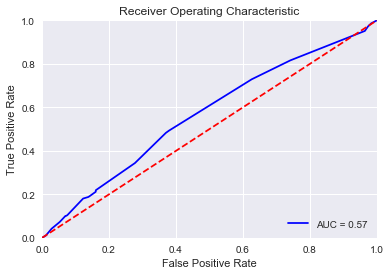

In [50]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
metrics.roc_auc_score(y_test, pred_test_prob[:,1])

0.5655562106918239

In [35]:
metrics.accuracy_score(y_test, pred_test)

0.6210268948655256

### GBM

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from IPython.core.display import HTML
import matplotlib.pyplot as plt

In [52]:
X_train, X_test, y_train, y_test = train_test_split(pop_data, pop_target, test_size=0.2, random_state=2018, shuffle=True)

In [66]:
#1)
gbm = GradientBoostingClassifier(random_state=2018, n_estimators=100, verbose=1)
#2)
#gbm = GradientBoostingClassifier(max_depth=5, random_state=2018, n_estimators=100, verbose=1)

gbm = gbm.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2467           10.83s
         2           1.2299           12.32s
         3           1.2147           11.94s
         4           1.2004           11.91s
         5           1.1843           11.59s
         6           1.1712           11.58s
         7           1.1562           11.44s
         8           1.1460           11.33s
         9           1.1335           11.04s
        10           1.1230           11.09s
        20           1.0299            9.10s
        30           0.9618            7.62s
        40           0.8999            6.28s
        50           0.8459            5.16s
        60           0.8050            4.02s
        70           0.7602            2.96s
        80           0.7253            1.93s
        90           0.6879            0.96s
       100           0.6578            0.00s


In [67]:
pred_test = gbm.predict(X_test)
pred_test_prob = gbm.predict_proba(X_test)

In [68]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

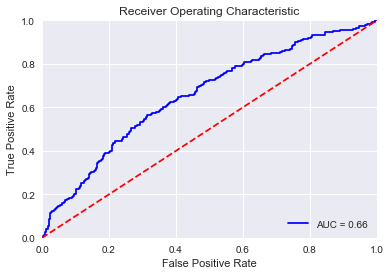

In [69]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [70]:
metrics.roc_auc_score(y_test, pred_test_prob[:,1])

0.6552345387840671

In [71]:
metrics.accuracy_score(y_test, pred_test)

0.6625916870415648

### KNN

In [94]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 

In [95]:
X_train, X_test, y_train, y_test = train_test_split(pop_data, pop_target, test_size=0.2, random_state=2018, shuffle=True)

In [96]:
print(X_train.shape)
print(X_test.shape)

(3268, 517)
(818, 517)


In [97]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

In [98]:
knn = KNeighborsClassifier(n_neighbors=7)
knn = knn.fit(X_train, y_train)

In [99]:
pred_test = knn.predict(X_test)
pred_test_prob = knn.predict_proba(X_test)

In [100]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

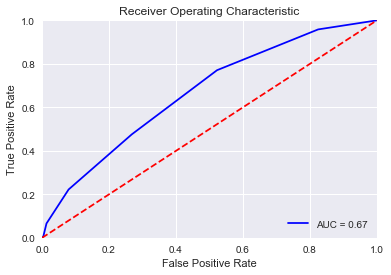

In [101]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [102]:
metrics.roc_auc_score(y_test, pred_test_prob[:,1])

0.667292321802935

In [103]:
metrics.accuracy_score(y_test, pred_test)

0.6748166259168704

### SVM

In [104]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler  

In [105]:
X_train, X_test, y_train, y_test = train_test_split(pop_data, pop_target, test_size=0.2, random_state=2018, shuffle=True)

In [106]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [107]:
svmc = svm.SVC(kernel='rbf', C=1000, probability=True, random_state=2018)
svmc = svmc.fit(X_train, y_train)

In [108]:
pred_test = svmc.predict(X_test)
pred_test_prob = svmc.predict_proba(X_test)

In [109]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

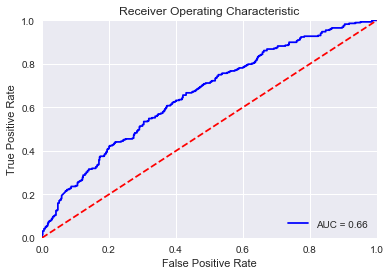

In [110]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [111]:
metrics.roc_auc_score(y_test, pred_test_prob[:,1])

0.6600759958071278

In [112]:
metrics.accuracy_score(y_test, pred_test)

0.6613691931540342

In [113]:
confmat = metrics.confusion_matrix(y_test, pred_test)

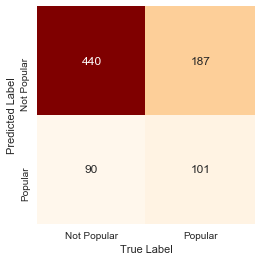

In [114]:
sns.heatmap(confmat.T, square=True, annot=True, fmt='d', cbar=False, cmap="OrRd",
            xticklabels=['Not Popular','Popular'], yticklabels=['Not Popular','Popular'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');

## Final Prediction

In [132]:
X_sample = sample_data
y_sample = sample_target


pred_sample = svmc.predict(X_sample)
pred_sample_prob = svmc.predict_proba(X_sample)

#print(X_sample)
#print(y_sample)
print(pred_sample)
print(y_sample)
#print(pred_sample_prob)

print('Overall Accuracy', metrics.accuracy_score(y_sample, pred_sample))

[0 0 0 0 0 0 0 0]
[0 0 0 1 1 1 1 1]
Overall Accuracy 0.375
